In [5]:
# Custom extra width cells
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

### Information about the datasets

#### Washingpost dataset
In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the person was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media, and by monitoring independent databases such as Killed by Police and Fatal Encounters. The Post conducted additional reporting in many cases.


#### Mapping Police Violence
This information has been meticulously sourced from the three largest, most comprehensive and impartial crowdsourced databases on police killings in the country: FatalEncounters.org, the U.S. Police Shootings Database and KilledbyPolice.net. We've also done extensive original research to further improve the quality and completeness of the data; searching social media, obituaries, criminal records databases, police reports and other sources to identify the race of 90 percent of all victims in the database.


#### Important notes
Washingpost sources theur data also from the mapping police violence dataset, but they cleaned the data. Meaning that the  mapping police violence dataset has more entries because it also has some NaN values, which could still be of interest for us.

### Opening the data and basic inspection

In [9]:
# Data dir path from root of project
data_dir = "./data"

# https://github.com/washingtonpost/data-police-shootings
df_wsp = pd.read_csv(f'{data_dir}/fatal-police-shootings-data-wsp.csv')  

# Output the first entries and info about the data in the set
display(df_wsp.head())
display(df_wsp.info())

# Output indecent lenght of both datasets
# wsp_len = str(len(df_wsp))
# print(f"Washingpost data-police-shootings has {wsp_len} entries")


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5716 non-null   int64  
 1   name                     5499 non-null   object 
 2   date                     5716 non-null   object 
 3   manner_of_death          5716 non-null   object 
 4   armed                    5503 non-null   object 
 5   age                      5456 non-null   float64
 6   gender                   5715 non-null   object 
 7   race                     5109 non-null   object 
 8   city                     5716 non-null   object 
 9   state                    5716 non-null   object 
 10  signs_of_mental_illness  5716 non-null   bool   
 11  threat_level             5716 non-null   object 
 12  flee                     5426 non-null   object 
 13  body_camera              5716 non-null   bool   
 14  longitude               

None

### Check for duplicates and null values
We see that we don't have any duplicates

We do see that we seem to miss some important values like armed, age, race, flee.
Especially race is very important in our analysis.


In [53]:
display(df_wsp.duplicated().sum())
display(df_wsp.isnull().sum())

0

id                           0
name                       217
date                         0
manner_of_death              0
armed                      213
age                        260
gender                       1
race                       607
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       290
body_camera                  0
longitude                  279
latitude                   279
is_geocoding_exact           0
dtype: int64

## Convert columns to right value

### Convert data to datetime value 

In [29]:
# Convert dae to datetime pandas value 
# https://stackoverflow.com/a/33368021/8970591
# errors=coerce -> 'if the conversion fails for any particular string then those rows are set to NaT'
# errors=raise -> then invalid parsing will raise an exception.
df_wsp['date'] = pd.to_datetime(df_wsp['date'], errors='raise')




### Encoding race values
We do miss about 600 entries of race.

This is the [original classification](https://github.com/washingtonpost/data-police-shootings):
race:

`race`:
- `W`: White, non-Hispanic
- `B`: Black, non-Hispanic
- `A`: Asian
- `N`: Native American
- `H`: Hispanic
- `O`: Other
- `None`: unknown

We want add weights the incident based on the actual amount of each race that lives in the US.

Used data [from wikipedia](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States#Racial_categories):
- `W`: 0.601
- `B`: 0.134
- `A`: 0.059
- `N`: 0.013
- `H`: 0.185
- `O`: 0.008


In [67]:
# Double check our different values 
display(df_wsp['race'].unique())

# Add the weighted race values from wikipedia 
race_ratios = {
    'W': 0.601,
    'B': 0.134,
    'A': 0.059,
    'N': 0.013,
    'H': 0.185,
    'O': 0.008,
}




# TODO:Impute the unkown values


array(['A', 'W', 'H', 'B', 'O', nan, 'N'], dtype=object)

In [54]:
def plot_value_counts_barchart(df_plot, class_key, verbose=False, normalize=False,
                               is_custom=False, custom_values=None):
    # Grab the value counts, and use custom ones if needed
    # e.g. date or categroical group
    if is_custom:
        df_values = custom_values
    else:
        df_values = df_plot[class_key].value_counts(normalize=normalize)
    
    if verbose:
        display(df_values)
    
    # Create the plot ax object
    ax = df_values.plot(kind='bar', figsize=(14,8))
    
    # Set and rotate the labels for better readability 
#     ax.set_xticklabels(preds, rotation=45, direction="in", rotation_mode="anchor")
    ax.tick_params(axis='x', rotation=45, direction="in",)
    
    # Set the labels
    ax.set_xlabel(class_key.capitalize(), fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    
    # Create the title extenstion and then set title
    title_ext_norm = " - Normalized" if normalize == True else ""
    ax.set_title(f"Incident frequency by {class_key.capitalize()}{title_ext_norm}", fontsize=18)
    
    plt.show()
 

### State by state 
We see that CA, TX and FL by far have the most police indcident. If you look at the normalized (so by ratio), chart you see an even bigger.

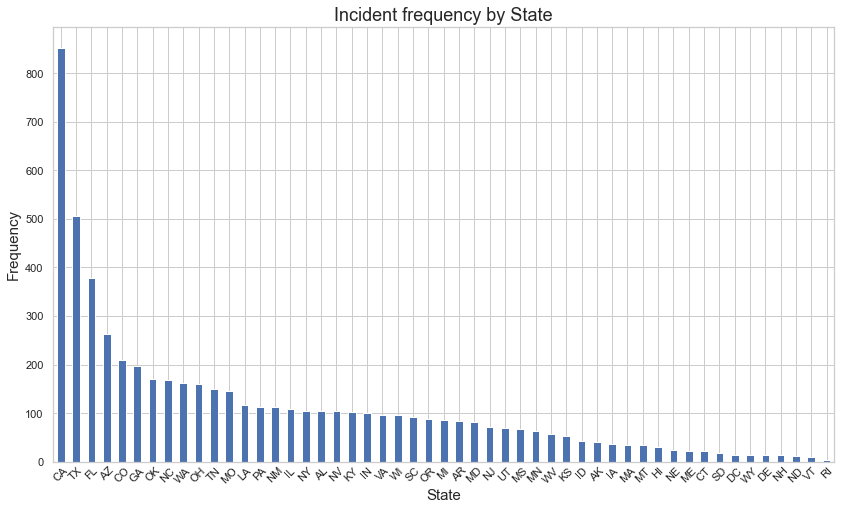

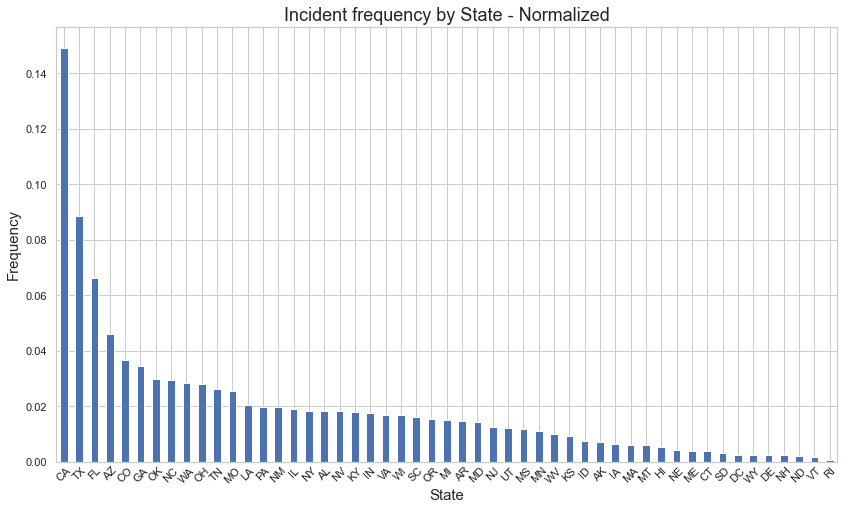

In [55]:
# WSP: Get incident state counts
per_state_df = df_wsp.groupby(["state"])

# Plot state by state count 
plot_value_counts_barchart(df_wsp, 'state', verbose=False, normalize=False)

# Plot state by state count 
plot_value_counts_barchart(df_wsp, 'state', verbose=False, normalize=True)


### Year by year for all incidents
There doesn't seem to be a very clear indication that the indicents grew on year to year basis 

This data was sourced at the 10th month of 2020, so 2020 could at the end of this year also be similar to the previous years

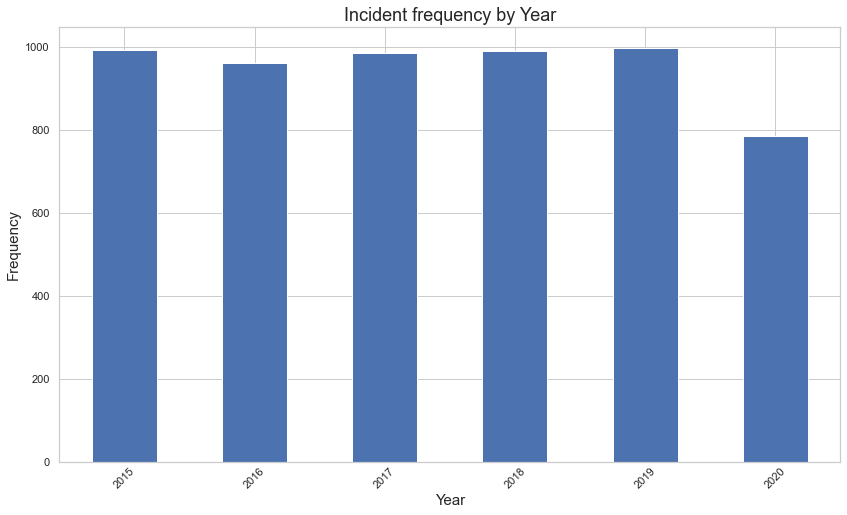

In [56]:
# Plot state by year 
df_by_year = df_wsp['date'].groupby([df_wsp.date.dt.year]).agg('count')
plot_value_counts_barchart(df_wsp, 'year', is_custom=True, custom_values=df_by_year)


### Indicents by race

This is the [original classification](https://github.com/washingtonpost/data-police-shootings):
race:

`race`:
- `W`: White, non-Hispanic
- `B`: Black, non-Hispanic
- `A`: Asian
- `N`: Native American
- `H`: Hispanic
- `O`: Other
- `None`: unknown


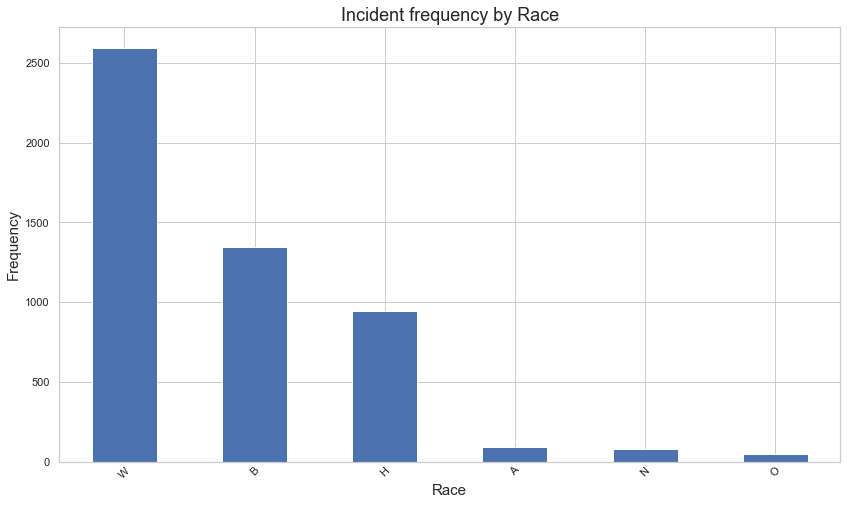

In [72]:

# Get weighted values
df_by_race = df_wsp['race'].value_counts()
df_by_race.head()


# df_race_weighted = TODO 

# Plot state by race
plot_value_counts_barchart(df_wsp, 'race')

# # Plot normalized by race 
# plot_value_counts_barchart(df_wsp, 'race', normalize=True)

